# Deep learning the collisional cross sections of the peptide universe from a million experimental values

Florian Meier, Niklas D. Köhler, Andreas-David Brunner, Jean-Marc H. Wanka, Eugenia Voytik, Maximilian T. Strauss, Fabian J. Theis, Matthias Mann

Pre-print: https://doi.org/10.1101/2020.05.19.102285  
Publication: pending

revised 09/2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.colors

import glob

from scipy import stats
from scipy import optimize

#### Import raw data from MaxQuant output

In [2]:
# Load evidence.txt files from folder
filenames = glob.glob("data/evidence*.txt")
evidences = [pd.read_csv(filename, sep='\t', engine='python', header=0) for filename in filenames]

# Combine all evidences in one dataframe
evidence_all = pd.concat(evidences, sort=False, ignore_index = True)

# Clean up 
del evidences

evidence_all.head()

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages (Trypsin/P),Missed cleavages (LysN),...,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,AIF MS/MS IDs,Oxidation (M) site IDs,Missed cleavages,Unnamed: 0,1/K0
0,AAAAAAAEAAAAAEAAAAAAAEAAAEQK,28,Unmodified,_AAAAAAAEAAAAAEAAAAAAAEAAAEQK_,NaN,NaN,0,0,0.0,1.0,...,66,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAEAAAAAEAAAAAAAEAAAEQK,28,Unmodified,_AAAAAAAEAAAAAEAAAAAAAEAAAEQK_,NaN,NaN,0,0,0.0,1.0,...,66,0,0,1,1,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAEAAASTTNGEANGVQESAATESK,30,Unmodified,_AAAAAAAEAAASTTNGEANGVQESAATESK_,NaN,NaN,0,0,0.0,1.0,...,4253,1,1,2,2,NaN,NaN,NaN,NaN,NaN
3,AAAADAAGDAADNGTSK,17,Unmodified,_AAAADAAGDAADNGTSK_,NaN,NaN,0,0,0.0,1.0,...,5600,2,2,3,3,NaN,NaN,NaN,NaN,NaN
4,AAAADAAGDAADNGTSK,17,Unmodified,_AAAADAAGDAADNGTSK_,NaN,NaN,0,0,0.0,1.0,...,5600,2,2,4,4,NaN,NaN,NaN,NaN,NaN


In [4]:
# Drop reverse hits
# Drop features with no intensity value

evidence_all = evidence_all.loc[(evidence_all['Reverse'] != '+') & (evidence_all['Intensity'] > 0)]

'{0} CCS values in the entire data set.'.format(len(evidence_all))

'2819987 CCS values in the entire data set.'

In [4]:
# Number of CCS values per Experiment
evidence_all['Experiment'].value_counts(), evidence_all['Experiment'].value_counts().sum()

(HeLa_Trypsin_1     611615
 HeLa_Trp_2         351335
 Drosophila_Trp     207089
 Yeast_Trypsin      172941
 Proteotypic        160778
 Yeast_LysC         158428
 Ecoli_trypsin      146548
 CElegans_Tryp      141263
 HeLa_LysN          124717
 Drosophila_LysC    116737
 Yeast_LysN         103072
 SRMATLAS           101740
 Drosophila_LysN    101401
 Ecoli_LysC          94580
 HeLa_LysC           84184
 Ecoli_LysN          76221
 MissingGeneSet      67338
 Name: Experiment, dtype: int64, 2819987)

### Construction of a very large scale peptide CCS data set

In [5]:
# Analysis of whole-proteome digests
group = ['CElegans_Tryp',
 'Drosophila_LysC',
 'Drosophila_LysN',
 'Drosophila_Trp',
 'Ecoli_LysC',
 'Ecoli_LysN',
 'Ecoli_trypsin',
 'HeLa_LysC',
 'HeLa_LysN',
 'HeLa_Trp_2',
 'HeLa_Trypsin_1',
 'Yeast_LysC',
 'Yeast_LysN',
 'Yeast_Trypsin']    

evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]
len(evidence_tmp)

2490131

<b>Figure 1b.<b/> Overview of the CCS data set in this study by organism.

In [6]:
print('Number of LC-MS/MS runs: {0}'.format(len(set(evidence_tmp['Raw file']))))
print('Number of peptide spectrum matches: {0}'.format(len(evidence_tmp['Raw file'])))
print('Number of unique CCS values (mod. sequence/charge): {0}'.format(len(set(evidence_tmp['Modified sequence'].astype(str) + evidence_tmp['Charge'].astype(str))), len(set(evidence_tmp['Sequence']))))
print('Number of unique peptide sequences: {0}'.format(len(set(evidence_tmp['Sequence']))))

Number of LC-MS/MS runs: 360
Number of peptide spectrum matches: 2490131
Number of unique CCS values (mod. sequence/charge): 571541
Number of unique peptide sequences: 426845


In [17]:
group = ['CElegans_Tryp']    

evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]
print('Number of PSMs/CCS values (C.elegans): {}'.format(len(evidence_tmp['Sequence'])))
print('Number of unique CCS values (C.elegans): {}'.format(len(set(evidence_tmp['Modified sequence'].astype(str) + evidence_tmp['Charge'].astype(str)))))

Number of PSMs/CCS values (C.elegans): 141263
Number of unique CCS values (C.elegans): 42253


In [18]:
group = ['Drosophila_LysC', 'Drosophila_LysN', 'Drosophila_Trp']    

evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]
print('Number of PSMs/CCS values (Drosophila): {}'.format(len(evidence_tmp['Sequence'])))
print('Number of unique CCS values (Drosophila): {}'.format(len(set(evidence_tmp['Modified sequence'].astype(str) + evidence_tmp['Charge'].astype(str)))))

Number of PSMs/CCS values (Drosophila): 425227
Number of unique CCS values (Drosophila): 102703


In [19]:
group = ['Ecoli_LysC', 'Ecoli_LysN', 'Ecoli_trypsin']    

evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]
print('Number of PSMs/CCS values (E.coli): {}'.format(len(evidence_tmp['Sequence'])))
print('Number of unique CCS values (E.coli): {}'.format(len(set(evidence_tmp['Modified sequence'].astype(str) + evidence_tmp['Charge'].astype(str)))))

Number of PSMs/CCS values (E.coli): 317349
Number of unique CCS values (E.coli): 50593


In [20]:
group = ['HeLa_LysC', 'HeLa_LysN', 'HeLa_Trp_2', 'HeLa_Trypsin_1']    

evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]
print('Number of PSMs/CCS values (HeLa): {}'.format(len(evidence_tmp['Sequence'])))
print('Number of unique CCS values (HeLa): {}'.format(len(set(evidence_tmp['Modified sequence'].astype(str) + evidence_tmp['Charge'].astype(str)))))

Number of PSMs/CCS values (HeLa): 1171851
Number of unique CCS values (HeLa): 260818


In [21]:
group = ['Yeast_LysC', 'Yeast_LysN', 'Yeast_Trypsin']    

evidence_tmp= evidence_all.loc[evidence_all['Experiment'].isin(group)]
print('Number of PSMs/CCS values (Yeast): {}'.format(len(evidence_tmp['Sequence'])))
print('Number of unique CCS values (Yeast): {}'.format(len(set(evidence_tmp['Modified sequence'].astype(str) + evidence_tmp['Charge'].astype(str)))))

Number of PSMs/CCS values (Yeast): 434441
Number of unique CCS values (Yeast): 119177


In [51]:
group = ['CElegans_Tryp',
 'Drosophila_LysC',
 'Drosophila_Trp',
 'Ecoli_LysC',
 'Ecoli_trypsin',
 'HeLa_LysC',
 'HeLa_Trp_2',
 'HeLa_Trypsin_1',
 'Yeast_LysC',
 'Yeast_Trypsin']    

evidence_tmp= evidence_all.loc[evidence_all['Experiment'].isin(group)]
print('Number of unique CCS values (Trypsin and LysC): {}'.format(len(set(evidence_tmp['Modified sequence'].astype(str) + evidence_tmp['Charge'].astype(str)))))
print('Number of unique sequences (Trypsin and LysC): {}'.format(len(set(evidence_tmp['Sequence']))))

Number of unique CCS values (Trypsin and LysC): 455526
Number of unique sequences (Trypsin and LysC): 338192


In [55]:
# Unique peptide sequences contributed by trypsin and LysC data set
np.round(338192/426845*100,0)

79.0

In [53]:
group = ['Drosophila_LysN',
 'Ecoli_LysN',
 'HeLa_LysN',
 'Yeast_LysN']  

evidence_tmp= evidence_all.loc[evidence_all['Experiment'].isin(group)]
print('Number of unique CCS values (LysN): {}'.format(len(set(evidence_tmp['Modified sequence'].astype(str) + evidence_tmp['Charge'].astype(str)))))
print('Number of unique sequences (LysN): {}'.format(len(set(evidence_tmp['Sequence']))))

Number of unique CCS values (LysN): 116533
Number of unique sequences (LysN): 89093


In [57]:
# Unique peptide sequences contributed by LysN data set
np.round(89093/426845*100,0)

21.0

In [8]:
# Occurence of multiple features per modified sequence/charge state in single LC-MS runs.

group = ['CElegans_Tryp',
 'Drosophila_LysC',
 'Drosophila_LysN',
 'Drosophila_Trp',
 'Ecoli_LysC',
 'Ecoli_LysN',
 'Ecoli_trypsin',
 'HeLa_LysC',
 'HeLa_LysN',
 'HeLa_Trp_2',
 'HeLa_Trypsin_1',
 'Yeast_LysC',
 'Yeast_LysN',
 'Yeast_Trypsin']    

evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]

hist_data = evidence_tmp.groupby(['Modified sequence', 'Charge', 'Raw file']).count()
len(hist_data), len(evidence_tmp)

(2029123, 2490131)

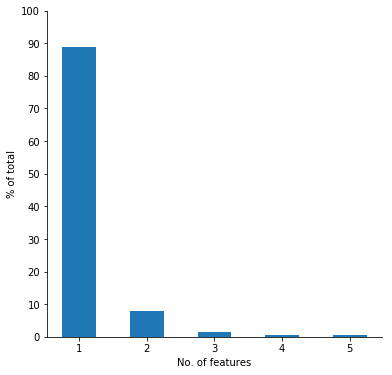

In [13]:
fig = plt.figure(figsize=(6,6))

ax = plt.axes()

plt.hist(x = hist_data['Sequence'], bins = 5, range = (1,6), align = 'left',
         weights= (np.zeros_like(hist_data['Sequence']) + 100) / hist_data['Sequence'].size,
        rwidth = 0.5)


plt.xlabel('No. of features')
plt.ylabel('% of total')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim((0,100))

plt.xticks(range(1,6))
plt.yticks(range(0,101,10))

plt.savefig("figures/Suppl_Fig_1.jpg");
plt.show()

<b>Supplementary Figure 1.</b> Number of detected features per modified peptide sequence and charge 
state in single LC-TIMS-MS experiments.  

In [9]:
# Reduce to unique modified sequence/charge state
evidence_unique = evidence_tmp.loc[evidence_tmp.groupby(['Modified sequence', 'Charge'])['Intensity'].idxmax()]
len(evidence_unique)

571541

In [10]:
# Reduce to unique sequence
evidence_unique_seq = evidence_tmp.loc[evidence_tmp.groupby(['Sequence'])['Intensity'].idxmax()]
len(evidence_unique_seq)

426845

Median peptide length:       14.0 amino acids
Minimum peptide length:        7.0 amino acids
Maximum peptide length:       55.0 amino acids


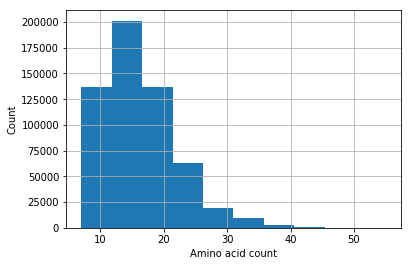

In [11]:
# Peptide length distribution 

print("Median peptide length: {:10.1f} amino acids".format(evidence_unique_seq['Length'].median()))
print("Minimum peptide length: {:10.1f} amino acids".format(evidence_unique_seq['Length'].min()))
print("Maximum peptide length: {:10.1f} amino acids".format(evidence_unique_seq['Length'].max()))


evidence_unique['Length'].hist()
plt.xlabel('Amino acid count')
plt.ylabel('Count');

In [12]:
cmap = plt.get_cmap("RdYlBu")
colors = cmap(np.linspace(0, 1, num=20))

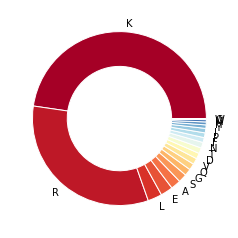

In [13]:
# C-terminal amino acids

fig, ax = plt.subplots()

size = 0.4
vals = np.array(evidence_unique_seq['Sequence'].str[-1:].value_counts())
labels = evidence_unique_seq['Sequence'].str[-1:].value_counts().index.tolist()

ax.pie(vals, radius=1, labels = labels, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
plt.savefig("figures/Figure_1_c.pdf")
plt.show()

<b>Figure 1c.</b> Frequency of peptide C-terminal amino acids.

In [14]:
np.sum(vals), vals, labels

(426845, array([203551, 139557,  11283,   9777,   7919,   6788,   5448,   5099,
          4888,   4569,   4530,   4514,   3883,   3784,   3560,   2741,
          2327,   1827,    445,    355], dtype=int64), ['K',
  'R',
  'L',
  'E',
  'A',
  'S',
  'G',
  'Q',
  'V',
  'D',
  'T',
  'N',
  'F',
  'P',
  'I',
  'Y',
  'H',
  'M',
  'C',
  'W'])

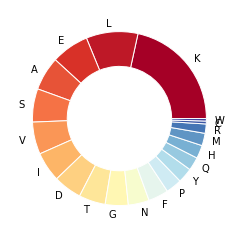

In [18]:
# N-terminal amino acids

fig, ax = plt.subplots()

size = 0.4
vals = np.array(evidence_unique_seq['Sequence'].str[:1].value_counts())
labels = evidence_unique_seq['Sequence'].str[:1].value_counts().index.tolist()

ax.pie(vals, radius=1, colors=colors, labels = labels,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
plt.savefig("figures/Figure_1_d.pdf")
plt.show()

<b>Figure 1d.</b> Frequency of peptide N-terminal amino acids.

In [19]:
np.sum(vals), vals, labels

(426845, array([92066, 41082, 29861, 26775, 26406, 25589, 23623, 22452, 21056,
        18239, 16634, 16009, 12708, 11827, 10578, 10473,  9844,  7402,
         2287,  1934], dtype=int64), ['K',
  'L',
  'E',
  'A',
  'S',
  'V',
  'I',
  'D',
  'T',
  'G',
  'N',
  'F',
  'P',
  'Y',
  'Q',
  'H',
  'M',
  'R',
  'C',
  'W'])

In [21]:
# Evaluate peptide charge distribution
evidence_unique['Charge'].value_counts() / np.sum(evidence_unique['Charge'].value_counts()) * 100

2    68.539615
3    25.168798
4     4.268635
1     2.022952
Name: Charge, dtype: float64

In [23]:
# Drop charge 1 features
evidence_unique = evidence_unique.loc[(evidence_unique['Charge'] != 1)]
len(evidence_unique)

559979

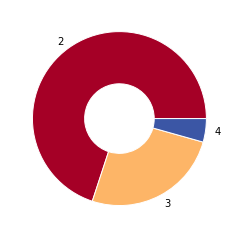

In [24]:
# Charge distribution
charge_color = [colors[0], colors[6], colors[18]]

fig, ax = plt.subplots()

size = 0.6
vals = np.array(evidence_unique['Charge'].value_counts())
labels = evidence_unique['Charge'].value_counts().index.tolist()

ax.pie(vals, radius=1, labels = labels, colors=charge_color,
       wedgeprops=dict(width=size, edgecolor='w'))


ax.set(aspect="equal")
plt.savefig("figures/Figure_1_e_Charge.pdf")
plt.show()

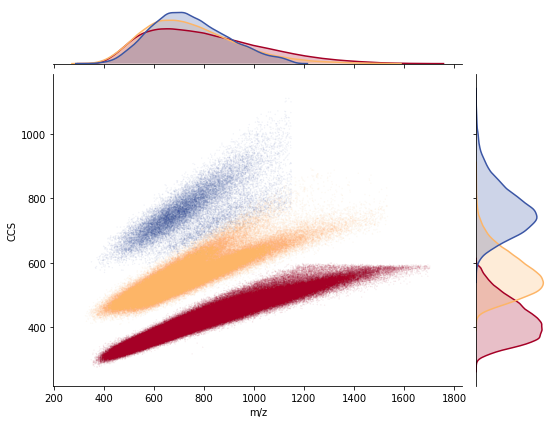

In [28]:
# m/z vs. CCS distribution

charge_color = {2: colors[0], 3: colors[6], 4: colors[18]}

grid = sns.JointGrid(x='m/z', y='CCS', data = evidence_unique)

g = grid.plot_joint(plt.scatter, c = evidence_unique['Charge'].apply(lambda x: charge_color[x]), data = evidence_unique, alpha = 0.1, s = .1)

g.fig.set_figwidth(8)
g.fig.set_figheight(6)

sns.kdeplot(evidence_unique.loc[evidence_unique['Charge']== 2, 'm/z'], ax=g.ax_marg_x, legend=False, shade = True, color = colors[0])
sns.kdeplot(evidence_unique.loc[evidence_unique['Charge']== 3, 'm/z'], ax=g.ax_marg_x, legend=False, shade = True, color = colors[6])
sns.kdeplot(evidence_unique.loc[evidence_unique['Charge']== 4, 'm/z'], ax=g.ax_marg_x, legend=False, shade = True, color = colors[18])

sns.kdeplot(evidence_unique.loc[evidence_unique['Charge']== 2, 'CCS'], ax=g.ax_marg_y, vertical=True, legend=False, shade = True, color = colors[0])
sns.kdeplot(evidence_unique.loc[evidence_unique['Charge']== 3, 'CCS'], ax=g.ax_marg_y, vertical=True, legend=False, shade = True, color = colors[6])
sns.kdeplot(evidence_unique.loc[evidence_unique['Charge']== 4, 'CCS'], ax=g.ax_marg_y, vertical=True, legend=False, shade = True, color = colors[18])

g.savefig("figures/Figure_1_e.jpg")

In [26]:
len(evidence_unique.loc[evidence_unique['Charge']== 2]), len(evidence_unique.loc[evidence_unique['Charge']== 3]), len(evidence_unique.loc[evidence_unique['Charge']== 4])

(391732, 143850, 24397)

In [27]:
len(evidence_unique.loc[evidence_unique['Charge']== 2]) + len(evidence_unique.loc[evidence_unique['Charge']== 3]) + len(evidence_unique.loc[evidence_unique['Charge']== 4])

559979

### Analysis of ion mobility trend lines

In [62]:
def trendline_func(x, a, b):
    return a * np.power(x, b)

In [60]:
# Subset tryptic peptides (C-terminal R or K)
evidence_tryptic = evidence_unique.loc[(evidence_unique['Sequence'].str[-1:] == 'R') | (evidence_unique['Sequence'].str[-1:] == 'K')]
len(evidence_tryptic)

452592

In [63]:
# Split data set by charge state
CCS_fit_charge2 = evidence_tryptic[evidence_tryptic['Charge'] == 2] 
CCS_fit_charge3 = evidence_tryptic[evidence_tryptic['Charge'] == 3] 
CCS_fit_charge4 = evidence_tryptic[evidence_tryptic['Charge'] == 4]

In [64]:
# Fit to power-law trend line
params_charge2, params_covariance_charge2 = optimize.curve_fit(trendline_func, CCS_fit_charge2['m/z'], CCS_fit_charge2['CCS'])
params_charge3, params_covariance_charge3 = optimize.curve_fit(trendline_func, CCS_fit_charge3['m/z'], CCS_fit_charge3['CCS'])
params_charge4, params_covariance_charge4 = optimize.curve_fit(trendline_func, CCS_fit_charge4['m/z'], CCS_fit_charge4['CCS'])

print('2+')
print(params_charge2, params_covariance_charge2)
print('---')
print('3+')
print(params_charge3, params_covariance_charge3)
print('---')
print('4+')
print(params_charge4, params_covariance_charge4)

2+
[15.3381895  0.4978696] [[ 5.51303448e-04 -5.34522115e-06]
 [-5.34522115e-06  5.19173704e-08]]
---
3+
[38.21481008  0.40970179] [[ 2.73247229e-02 -1.07841627e-04]
 [-1.07841627e-04  4.26216435e-07]]
---
4+
[53.99250465  0.40393929] [[ 5.71960944e-01 -1.60260150e-03]
 [-1.60260150e-03  4.49483224e-06]]


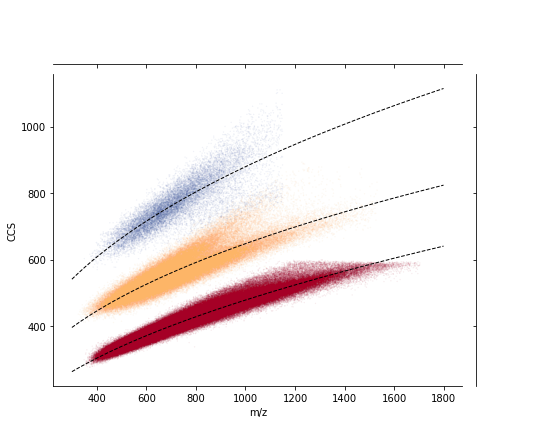

In [65]:
# m/z vs. CCS distribution

charge_color = {2: colors[0], 3: colors[6], 4: colors[18]}

grid = sns.JointGrid(x='m/z', y='CCS', data = evidence_tryptic)
g = grid.plot_joint(plt.scatter, c = evidence_tryptic['Charge'].apply(lambda x: charge_color[x]), data = evidence_tryptic, alpha = 0.1, s = .1)

plt.plot(np.arange(300,1800,1), trendline_func(np.arange(300,1800,1), params_charge2[0], params_charge2[1]), color = "black", ls = 'dashed', lw = 1)
plt.plot(np.arange(300,1800,1), trendline_func(np.arange(300,1800,1), params_charge3[0], params_charge3[1]), color = "black", ls = 'dashed', lw = 1)
plt.plot(np.arange(300,1800,1), trendline_func(np.arange(300,1800,1), params_charge4[0], params_charge4[1]), color = "black", ls = 'dashed', lw = 1)

g.fig.set_figwidth(8)
g.fig.set_figheight(6)

g.savefig("figures/Suppl_Fig_2a.jpg")

<b>Supplementary Figure 2a.</b> Distribution of tryptic peptides in the m/z vs. CCS space color-coded 
by charge state as in Figure 1. Fitted power-law (A*x^b)) trend lines (dashed lines) visualize the 
correlation of ion mass and mobility in each charge state.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


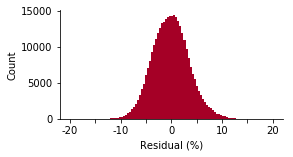

In [75]:
CCS_fit_charge2['Delta fit'] = (CCS_fit_charge2['CCS'] - trendline_func(CCS_fit_charge2['m/z'], params_charge2[0], params_charge2[1])) / CCS_fit_charge2['CCS'] * 100

plt.figure(figsize=(4,2))


ax = CCS_fit_charge2['Delta fit'].hist(bins = 100, range=(-20,20), color = colors[0])

plt.grid(b = False)

plt.xticks(np.arange(-20, 21, step=5), (-20, '', -10, '', 0, '', 10, '', 20))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.xlabel('Residual (%)')
plt.ylabel('Count');

plt.savefig("figures/Suppl_Fig_2b.jpg")

<b>Supplementary Figure 2b.</b> Residuals for charge state 2.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


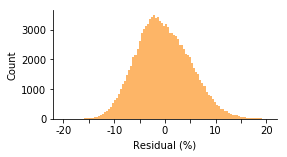

In [78]:
CCS_fit_charge3['Delta fit'] = (CCS_fit_charge3['CCS'] - trendline_func(CCS_fit_charge3['m/z'], params_charge3[0], params_charge3[1])) / CCS_fit_charge3['CCS'] * 100

plt.figure(figsize=(4,2))


ax = CCS_fit_charge3['Delta fit'].hist(bins = 100, range=(-20,20), color = colors[6])

plt.grid(b = False)

plt.xticks(np.arange(-20, 21, step=5), (-20, '', -10, '', 0, '', 10, '', 20))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.xlabel('Residual (%)')
plt.ylabel('Count');

plt.savefig("figures/Suppl_Fig_2c.jpg")

<b>Supplementary Figure 2c.</b> Residuals for charge state 3.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


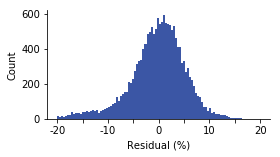

In [79]:
CCS_fit_charge4['Delta fit'] = (CCS_fit_charge4['CCS'] - trendline_func(CCS_fit_charge4['m/z'], params_charge4[0], params_charge4[1])) / CCS_fit_charge4['CCS'] * 100

plt.figure(figsize=(4,2))


ax = CCS_fit_charge4['Delta fit'].hist(bins = 100, range=(-20,20), color = colors[18])

plt.grid(b = False)

plt.xticks(np.arange(-20, 21, step=5), (-20, '', -10, '', 0, '', 10, '', 20))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.xlabel('Residual (%)')
plt.ylabel('Count');

plt.savefig("figures/Suppl_Fig_2d.jpg")

<b>Supplementary Figure 2d.</b> Residuals for charge state 4.

In [69]:
# Percentile distribution around trend line

CCS_fit = CCS_fit_charge2['Delta fit'].append(CCS_fit_charge3['Delta fit']).append(CCS_fit_charge4['Delta fit'])
np.percentile(CCS_fit, 2.5), np.percentile(CCS_fit, 97.5)

(-8.321646848482057, 8.067002741551253)

### Analysis of peak capacity

In [81]:
def calc_K0_from_CCS(CCS, charge, mass):
    mass = mass + charge * 1.00727647
    k0 = CCS * np.sqrt(305 * mass * 28 / (28 + mass)) * 1/18500 * 1/charge
    
    return k0

In [82]:
# Subset tryptic peptides (C-terminal R or K)
evidence_tryptic = evidence_unique.loc[(evidence_unique['Sequence'].str[-1:] == 'R') | (evidence_unique['Sequence'].str[-1:] == 'K')]
len(evidence_tryptic)

452592

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


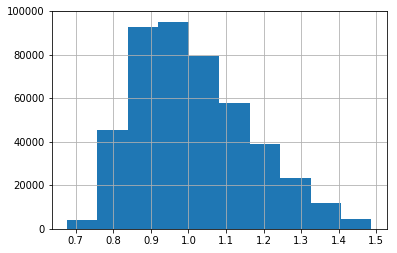

In [89]:
evidence_tryptic['1/K0'] = calc_K0_from_CCS(evidence_tryptic['CCS'], evidence_tryptic['Charge'], evidence_tryptic['Mass'])
evidence_tryptic['1/K0'].hist()

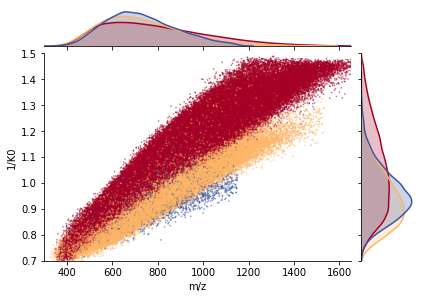

In [88]:
charge_color = {2: colors[0], 3: colors[6], 4: colors[18]}

grid = sns.JointGrid(x='m/z', y='1/K0', data = evidence_tryptic)

g = grid.plot_joint(plt.scatter, c = evidence_tryptic['Charge'].apply(lambda x: charge_color[x]), data = evidence_tryptic, alpha = .5, s = .5)

g.fig.set_figwidth(6)
g.fig.set_figheight(4)

sns.kdeplot(evidence_tryptic.loc[evidence_tryptic['Charge']== 2, 'm/z'], ax=g.ax_marg_x, legend=False, shade = True, color = colors[0])
sns.kdeplot(evidence_tryptic.loc[evidence_tryptic['Charge']== 3, 'm/z'], ax=g.ax_marg_x, legend=False, shade = True, color = colors[6])
sns.kdeplot(evidence_tryptic.loc[evidence_tryptic['Charge']== 4, 'm/z'], ax=g.ax_marg_x, legend=False, shade = True, color = colors[18])

sns.kdeplot(evidence_tryptic.loc[evidence_tryptic['Charge']== 2, '1/K0'], ax=g.ax_marg_y, vertical=True, legend=False, shade = True, color = colors[0])
sns.kdeplot(evidence_tryptic.loc[evidence_tryptic['Charge']== 3, '1/K0'], ax=g.ax_marg_y, vertical=True, legend=False, shade = True, color = colors[6])
sns.kdeplot(evidence_tryptic.loc[evidence_tryptic['Charge']== 4, '1/K0'], ax=g.ax_marg_y, vertical=True, legend=False, shade = True, color = colors[18]);

plt.xlim(300,1650)
plt.ylim(0.7,1.5)

plt.savefig("figures/Suppl_Fig_3a.jpg");

<b>Supplementary Figure 3a.</b> Distribution of tryptic peptides in the m/z vs. ion mobility (1/K0) 
space color-coded by charge state as in Figure 1.

In [101]:
xbins = 1350
ybins = 44

hist, xedges, yedges = np.histogram2d(evidence_tryptic['m/z'], 
                                      evidence_tryptic['1/K0'], 
                                      bins=[xbins,ybins], 
                                      range=[[300, 1650], [0.7, 1.5]])

over_threshold = hist > 1

print('Fraction of peptides:')
print(np.round((np.nansum((10**np.log10(hist-1))) / hist.sum().sum() ), 2))
print('Occupancy of the 2D space:')
print(np.round(sum((sum(over_threshold))/(xbins*ybins)),2))

Fraction of peptides:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


0.96
Occupancy of the 2D space:
0.27


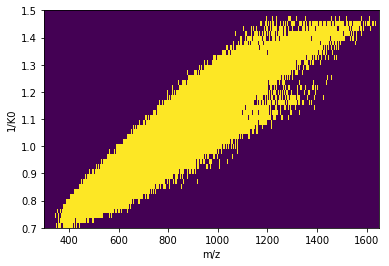

In [91]:
fig = plt.figure(figsize=(6,4))

    
plt.xlabel('m/z')
plt.ylabel('1/K0');

XB = xedges
YB = yedges
X,Y = np.meshgrid(xedges,yedges)
Z = over_threshold.T
plt.pcolormesh(X, Y, Z);

plt.savefig("figures/Suppl_Fig_3b.jpg")

<b>Supplementary Figure 3b.</b> Estimating the peak capacity (Φ) of two-
dimensional peptide separation with TIMS-MS. In an ideally orthogonal 2D separation, the total 
peak capacity would be ΦMS \* ΦTIMS. Assuming an ion mobility resolution of 60 ((1/K0) / Δ(1/K0)), 
the average peak full width at half maximum is 0.018 Vs cm-2 in the peptide 1/K0 range (0.7-1.5 
Vs cm-2). This would result in a theoretical peak capacity of ΦMS \* 44. However, the correlation of 
mass and mobility reduces the effective peak capacity and the 2D histogram analysis (1350 m/z x 
44 ion mobility bins) shows that 96% of the peptides occupy about 27% of the total area (yellow 
vs. purple area). Using this as a correction factor, we estimate the peak capacity of TIMS-MS to 
about ΦMS \* 12.